In [1]:
#!pip install -U tensorflow-addons

  Using cached tensorflow_addons-0.19.0-cp37-cp37m-win_amd64.whl (742 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


In [6]:
#!pip install -q tensorflow==2.3
#!pip install -q keras==2.3
#!pip install -q tensorflow-estimator==2.3

In [1]:
!pip install opencv-python-headless

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_addons as tfa
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import os, cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau, CSVLogger, LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import load_model, save_model
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
plt.style.use("ggplot")
import math
print(tf.__version__, tf.keras.__version__)

print(tf.test.is_built_with_cuda())

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))



2023-07-26 08:23:05.974984: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0 2.11.0
True
Num GPUs: 1


In [3]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            #img = circle_crop(img)
            img = cv2.resize(img, (224,224))
            #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2XYZ)
            images.append(img)
           
    return np.array(images)

In [4]:
checkpoint_filepath = '/workspace/Vidhi/paper1/'
total_Normal = '/workspace/Vidhi/noduledataset/NORM_CT'
total_Abnormal='/workspace/Vidhi/noduledataset/ABNORM_CT'


In [5]:
samples = load_images(total_Normal)
samples1 = load_images(total_Abnormal)
indices=[]
labels=[]
for i in range(len(samples)):
    labels.append(0)
for i in range(len(samples1)):
    labels.append(1)
labels = np.asarray(labels)
samples = np.concatenate((samples, samples1))


indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]


print(indices.shape)
print(labels.shape)
print(samples.shape)
# normalize pictures
#samples = samples.astype('float32') / 255

(19419,)
(19419,)
(19419, 224, 224, 3)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state=0)

print('y array', x_train.shape)
print('y array', y_train.shape)

print('y_val array', x_val.shape)
print('y_val array', y_val.shape)

print('y array', x_test.shape)
print('y array', y_test.shape)

y array (15535, 224, 224, 3)
y array (15535,)
y_val array (1942, 224, 224, 3)
y_val array (1942,)
y array (1942, 224, 224, 3)
y array (1942,)


In [7]:
vgg = VGG16(input_shape = (224,224,3), weights='imagenet', include_top=False)
#resnet = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
incepnet = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
#xcepnet = Xception(input_shape=(224,224,3), weights='imagenet', include_top=False)
#densenet = DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False)
#incepresnet = InceptionResNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
#mobilenet = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
#efficientnet = EfficientNetB0(input_shape=(224,224,3), weights='imagenet', include_top=False)

2023-07-26 08:24:06.997843: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 08:24:07.091994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38318 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [8]:
## VGG
def create_vgg():
    for layer in vgg.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(vgg.output)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=vgg.input, outputs=out)
    return model


In [8]:
##ResNet
##Compiling ResNet
def create_resnet():
    for layer in resnet.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(resnet.output)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=resnet.input, outputs=out)
    return model

In [9]:
##Compiling Inception
def create_incepnet():
    for layer in incepnet.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(incepnet.output)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=incepnet.input, outputs=out)
    return model

In [12]:
##Compiling densenet
def create_densenet(): 
    ##Compiling DenseNet
    for layer in densenet.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(densenet.output)
    pred = layers.Dense(1, activation='sigmoid')(x)

    model_d121 = tf.keras.Model(inputs=densenet.input, outputs=pred)
    return model_d121

In [21]:
##Compiling InceptionResNet
def create_incepnetresnet(): 
    for layer in incepresnet.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(incepresnet.output)
    pred = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=incepresnet.input, outputs=pred)
    return model

In [10]:
##Compiling Xception
def create_xcepnet(): 
    for layer in xcepnet.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(xcepnet.output)
    pred = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=xcepnet.input, outputs=pred)
    return model

In [11]:
##Compiling Efficientnet
def create_efficientnet(): 
    for layer in efficientnet.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(efficientnet.output)
    pred = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=efficientnet.input, outputs=pred)
    return model

In [31]:
##Compiling mobilenet
def create_mobilenet(): 
    for layer in mobilenet.layers:
        layer.trainable = False 
    
    x = layers.Flatten()(mobilenet.output)
    pred = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=mobilenet.input, outputs=pred)
    return model

In [13]:
#model_v = create_vgg()
model_r = create_resnet()
#model_i = create_incepnet()
model_d = create_densenet()
#model_ir = create_incepnetresnet()
model_x = create_xcepnet()
model_e = create_efficientnet()
#model_m = create_mobilenet()

In [18]:
#hist_v, model_v = run_model(model_v, "vgg")
hist_r, model_r = run_model(model_r, "resnet")
#hist_i, model_i = run_model(model_i, "incepnet")
hist_d, model_d = run_model(model_d, "densenet")
hist_x, model_x =run_model(model_x, "xceptnet")
hist_e, model_e = run_model(model_e, "efficientnet")
hist_m, model_m = run_model(model_m, "mobilenet")

Epoch 1/100
43/43 [==============================] - 4s 40ms/step - loss: 0.3100 - accuracy: 0.9496 - recall_4: 0.9141 - precision_4: 0.9118 - specificity_at_sensitivity_4: 0.9784 - auc_4: 0.9688 - val_loss: 0.2949 - val_accuracy: 0.9532 - val_recall_4: 0.9423 - val_precision_4: 0.9074 - val_specificity_at_sensitivity_4: 0.9748 - val_auc_4: 0.9750
Epoch 2/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0159 - accuracy: 0.9949 - recall_4: 0.9899 - precision_4: 0.9924 - specificity_at_sensitivity_4: 0.9990 - auc_4: 0.9994 - val_loss: 0.5677 - val_accuracy: 0.9415 - val_recall_4: 0.9615 - val_precision_4: 0.8621 - val_specificity_at_sensitivity_4: 0.9580 - val_auc_4: 0.9754
Epoch 3/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0242 - accuracy: 0.9949 - recall_4: 0.9899 - precision_4: 0.9924 - specificity_at_sensitivity_4: 0.9990 - auc_4: 0.9981 - val_loss: 0.2622 - val_accuracy: 0.9415 - val_recall_4: 0.8846 - val_precision_4: 0.9200 - val_specifi

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

RESNET RESULTS
22/22 [==============================] - 1s 10ms/step


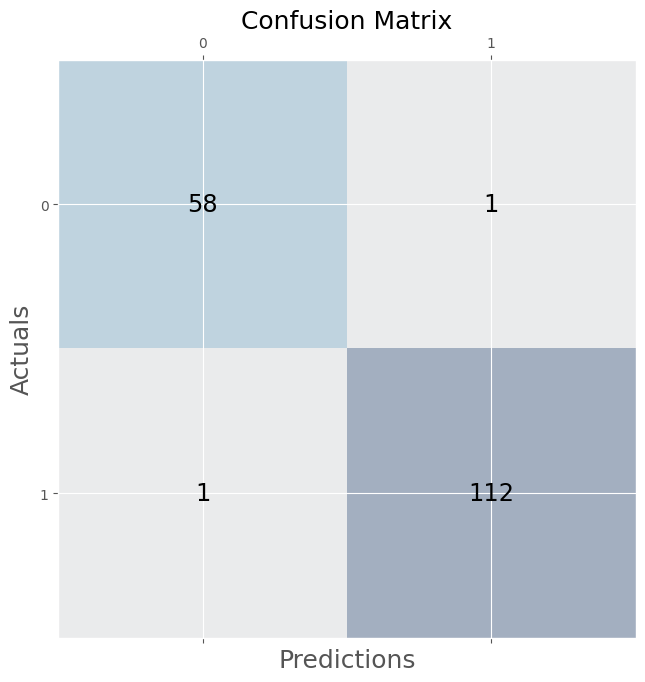

Accuracy  : 0.9883720930232558
Recall : 0.9883720930232558
specificity : 0.9830508474576272
Precision : 0.9883720930232558
f1Score : 0.9830508474576272
kappa score : 0.9742012899355033
gmean : 0.9857078794703735
Confusion Matrix

[[ 58   1]
 [  1 112]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.99      0.99       113
      NORMAL       0.98      0.98      0.98        59

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172

AUC-ROC: 0.9871006449677516


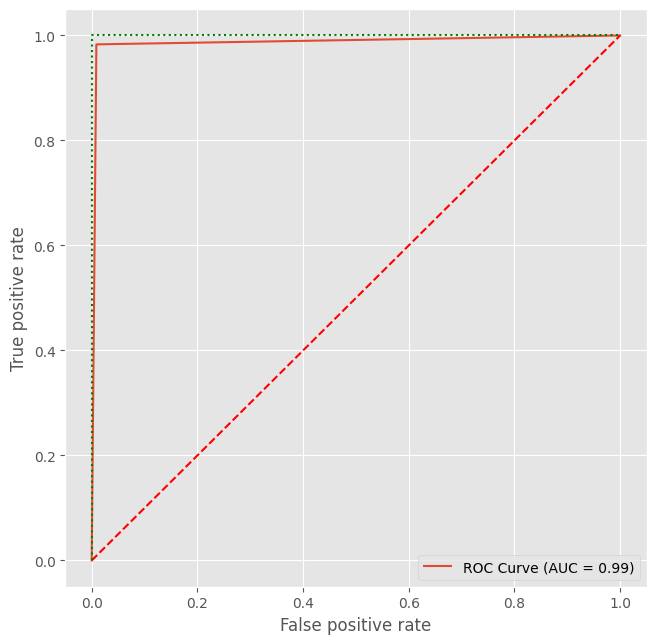

DENSENET RESULTS
22/22 [==============================] - 2s 11ms/step


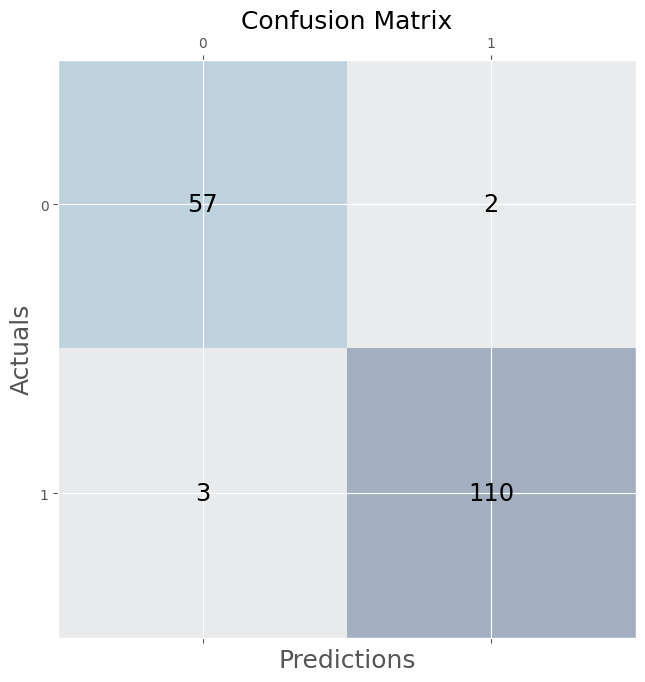

Accuracy  : 0.9709302325581395
Recall : 0.9709302325581395
specificity : 0.9661016949152542
Precision : 0.9711171096345514
f1Score : 0.957983193277311
kappa score : 0.9357633701822528
gmean : 0.9685129546469063
Confusion Matrix

[[ 57   2]
 [  3 110]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.98      0.97      0.98       113
      NORMAL       0.95      0.97      0.96        59

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172

AUC-ROC: 0.9697765111744413


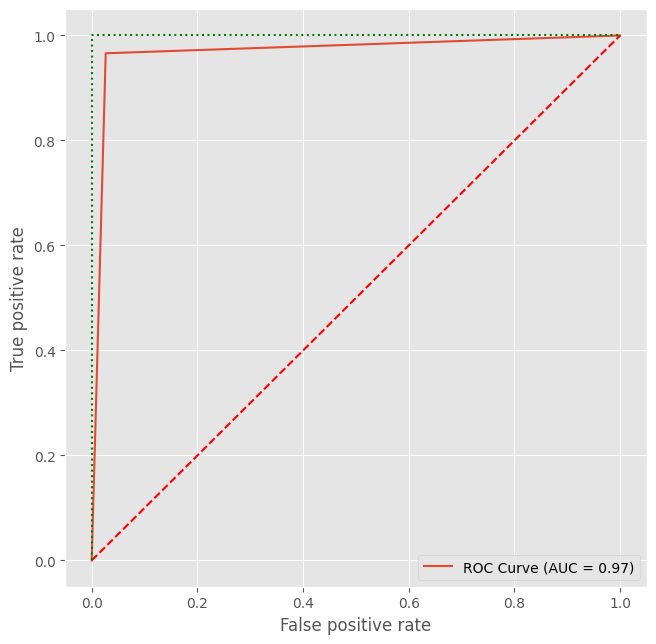

XCEPTION RESULTS
22/22 [==============================] - 1s 7ms/step


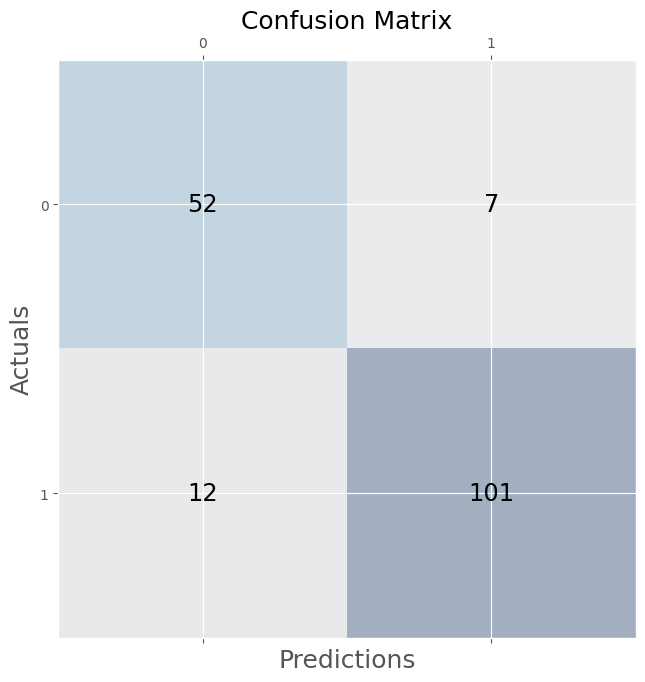

Accuracy  : 0.8895348837209303
Recall : 0.8895348837209303
specificity : 0.8813559322033898
Precision : 0.8931013135228252
f1Score : 0.8455284552845529
kappa score : 0.7597765363128491
gmean : 0.8854359641833477
Confusion Matrix

[[ 52   7]
 [ 12 101]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.89      0.91       113
      NORMAL       0.81      0.88      0.85        59

    accuracy                           0.89       172
   macro avg       0.87      0.89      0.88       172
weighted avg       0.89      0.89      0.89       172

AUC-ROC: 0.8875806209689515


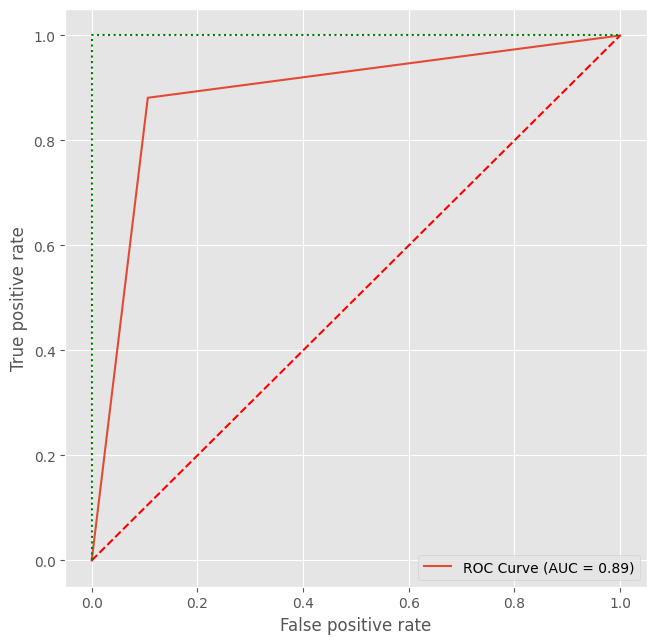

EFFICIENT RESULTS
22/22 [==============================] - 1s 6ms/step


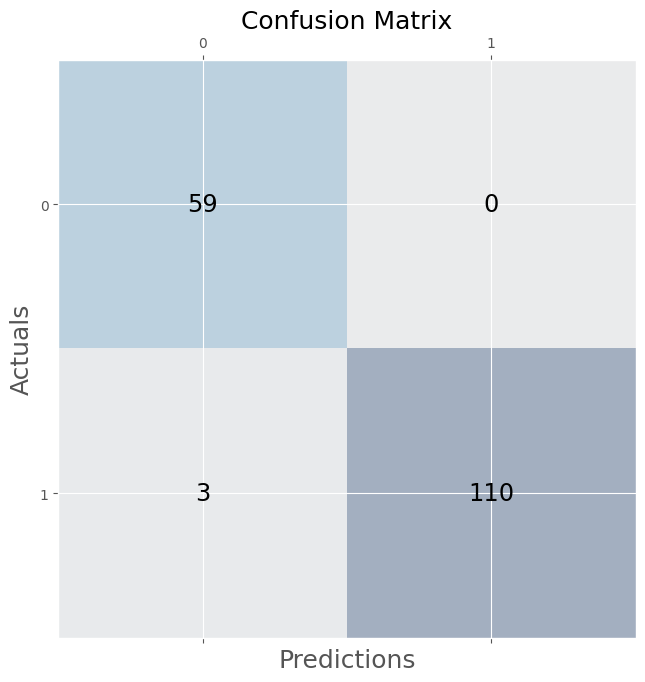

Accuracy  : 0.9825581395348837
Recall : 0.9825581395348837
specificity : 1.0
Precision : 0.9834021005251313
f1Score : 0.9752066115702479
kappa score : 0.9617664493183166
gmean : 0.9912407071619304
Confusion Matrix

[[ 59   0]
 [  3 110]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.97      0.99       113
      NORMAL       0.95      1.00      0.98        59

    accuracy                           0.98       172
   macro avg       0.98      0.99      0.98       172
weighted avg       0.98      0.98      0.98       172

AUC-ROC: 0.9867256637168141


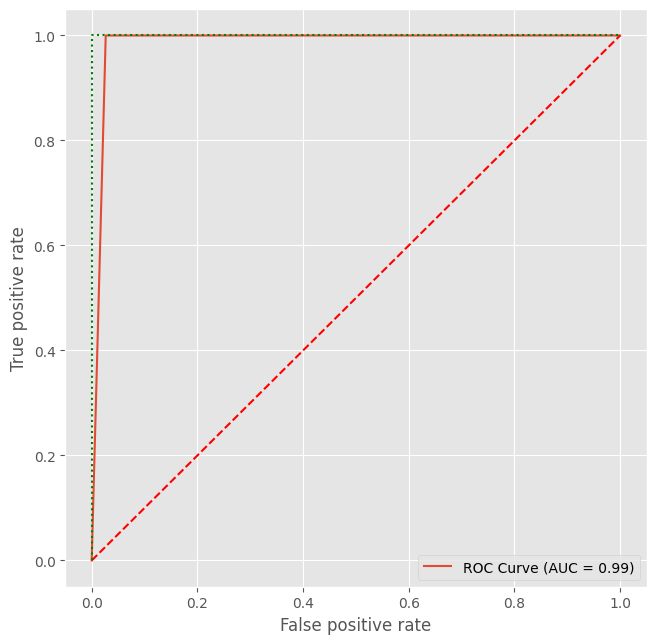

In [19]:
print("RESNET RESULTS")
bin_prediction(model_r, x_test, y_test)
#print("INCEPTION RESULTS")
#bin_prediction(model_i, x_test, y_test)
print("DENSENET RESULTS")
bin_prediction(model_d, x_test, y_test)
print("XCEPTION RESULTS")
bin_prediction(model_x, x_test, y_test)
print("EFFICIENT RESULTS")
bin_prediction(model_e, x_test, y_test)


TRAINING RESNET RESULTS
172/172 [==============================] - 1s 6ms/step


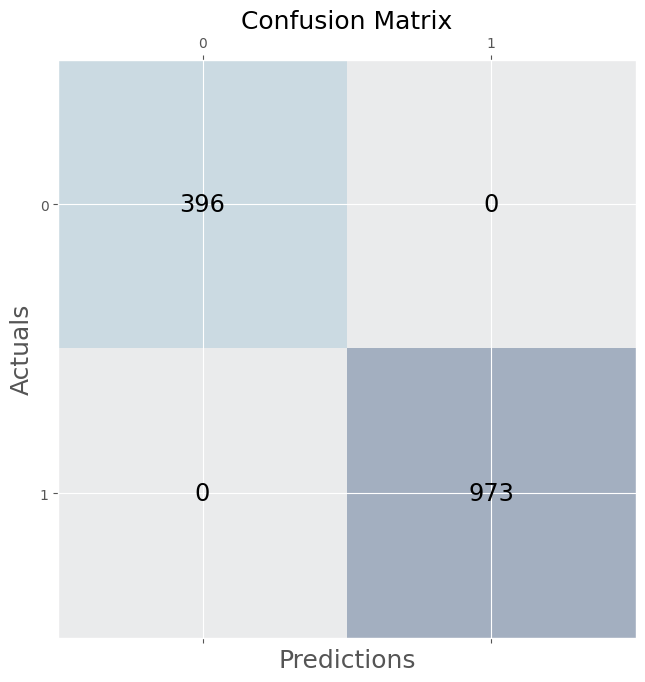

Accuracy  : 1.0
Recall : 1.0
specificity : 1.0
Precision : 1.0
f1Score : 1.0
kappa score : 1.0
gmean : 1.0
Confusion Matrix

[[396   0]
 [  0 973]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       1.00      1.00      1.00       973
      NORMAL       1.00      1.00      1.00       396

    accuracy                           1.00      1369
   macro avg       1.00      1.00      1.00      1369
weighted avg       1.00      1.00      1.00      1369

AUC-ROC: 1.0


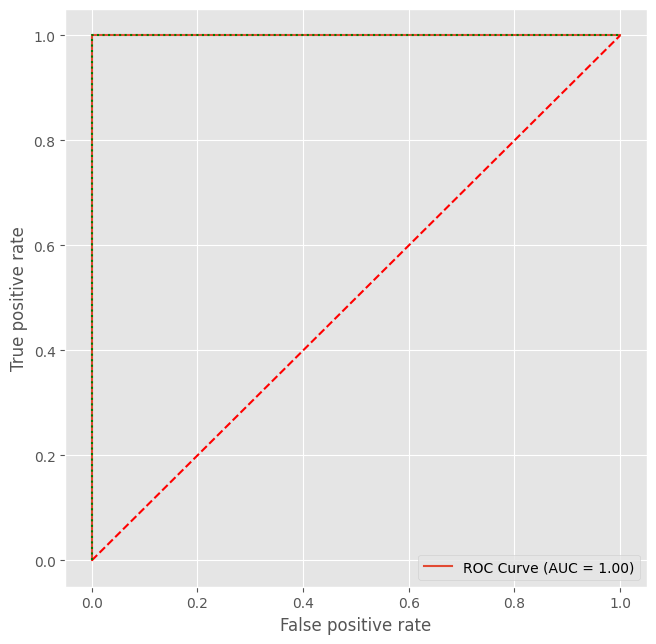

TRAINING DENSENET RESULTS
172/172 [==============================] - 2s 9ms/step


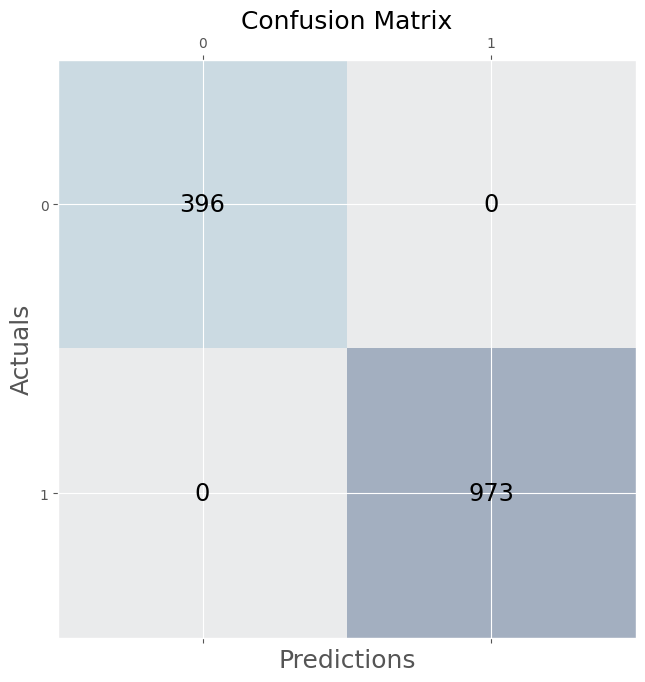

Accuracy  : 1.0
Recall : 1.0
specificity : 1.0
Precision : 1.0
f1Score : 1.0
kappa score : 1.0
gmean : 1.0
Confusion Matrix

[[396   0]
 [  0 973]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       1.00      1.00      1.00       973
      NORMAL       1.00      1.00      1.00       396

    accuracy                           1.00      1369
   macro avg       1.00      1.00      1.00      1369
weighted avg       1.00      1.00      1.00      1369

AUC-ROC: 1.0


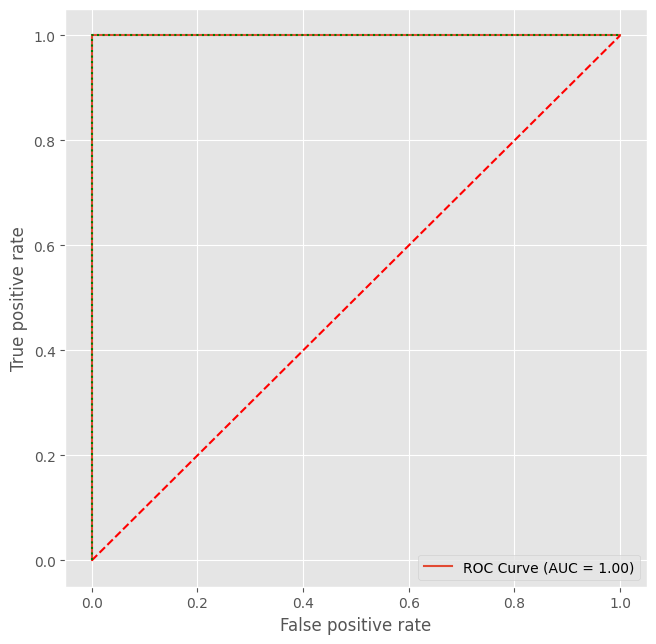

TRAINING XCEPTION RESULTS
172/172 [==============================] - 1s 5ms/step


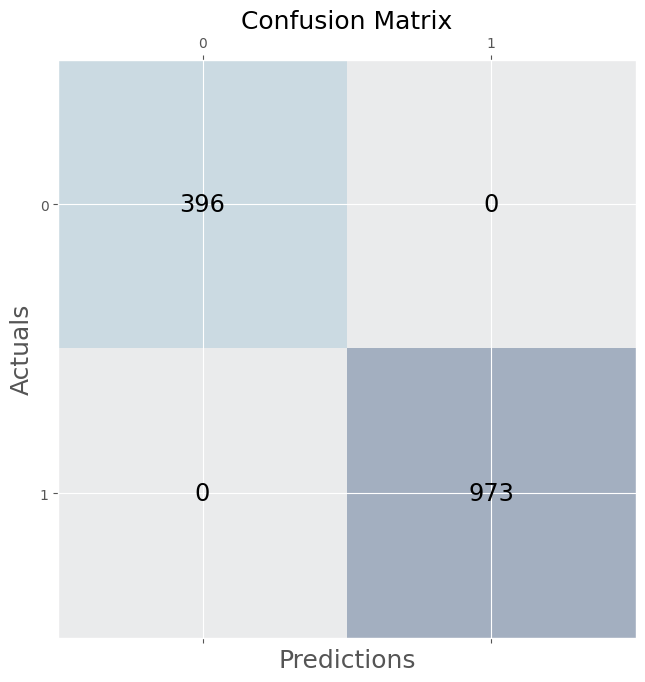

Accuracy  : 1.0
Recall : 1.0
specificity : 1.0
Precision : 1.0
f1Score : 1.0
kappa score : 1.0
gmean : 1.0
Confusion Matrix

[[396   0]
 [  0 973]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       1.00      1.00      1.00       973
      NORMAL       1.00      1.00      1.00       396

    accuracy                           1.00      1369
   macro avg       1.00      1.00      1.00      1369
weighted avg       1.00      1.00      1.00      1369

AUC-ROC: 1.0


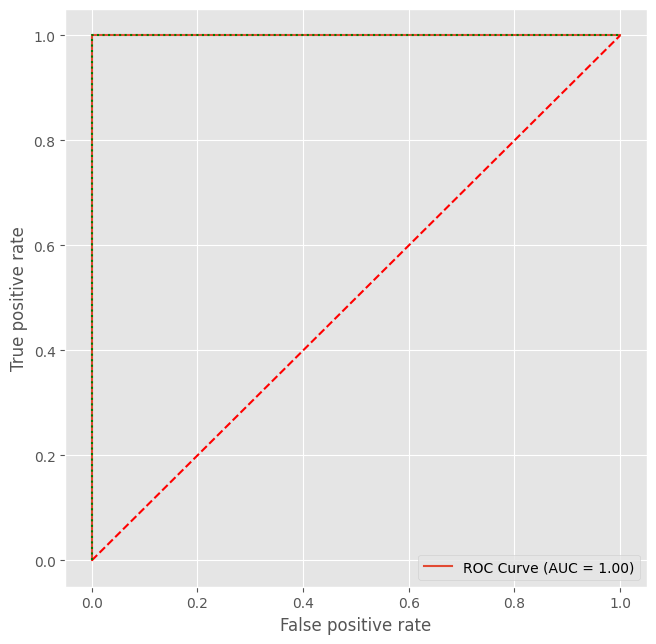

TRAINING EFFICIENTNET RESULTS
172/172 [==============================] - 1s 6ms/step


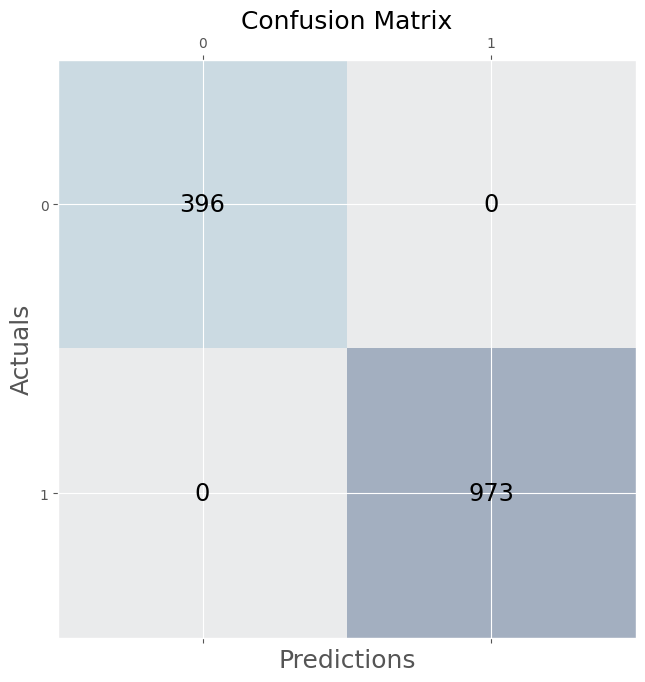

Accuracy  : 1.0
Recall : 1.0
specificity : 1.0
Precision : 1.0
f1Score : 1.0
kappa score : 1.0
gmean : 1.0
Confusion Matrix

[[396   0]
 [  0 973]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       1.00      1.00      1.00       973
      NORMAL       1.00      1.00      1.00       396

    accuracy                           1.00      1369
   macro avg       1.00      1.00      1.00      1369
weighted avg       1.00      1.00      1.00      1369

AUC-ROC: 1.0


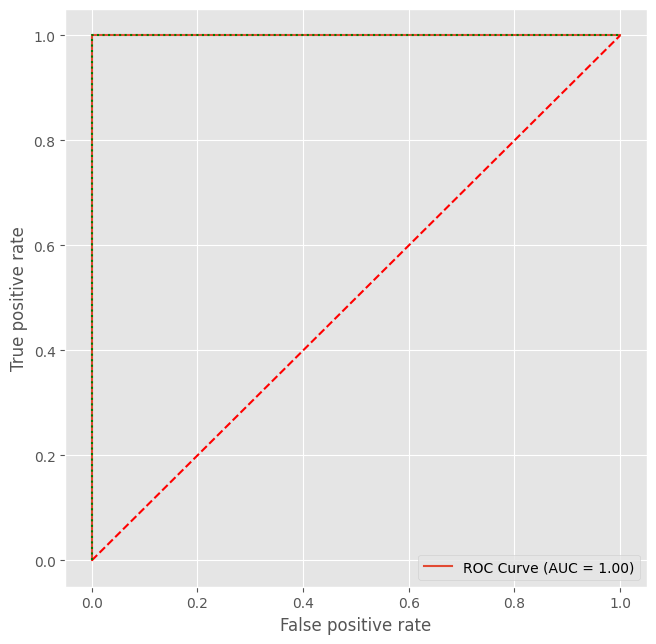

In [20]:
print("TRAINING RESNET RESULTS")
bin_prediction(model_r, x_train, y_train)
#print("TRAINING INCEPTION RESULTS")
#bin_prediction(model_i, x_train, y_train)
print("TRAINING DENSENET RESULTS")
bin_prediction(model_d, x_train, y_train)
print("TRAINING XCEPTION RESULTS")
bin_prediction(model_x, x_train, y_train)
print("TRAINING EFFICIENTNET RESULTS")
bin_prediction(model_e, x_train, y_train)

VALIDATION RESNET RESULTS
22/22 [==============================] - 0s 10ms/step


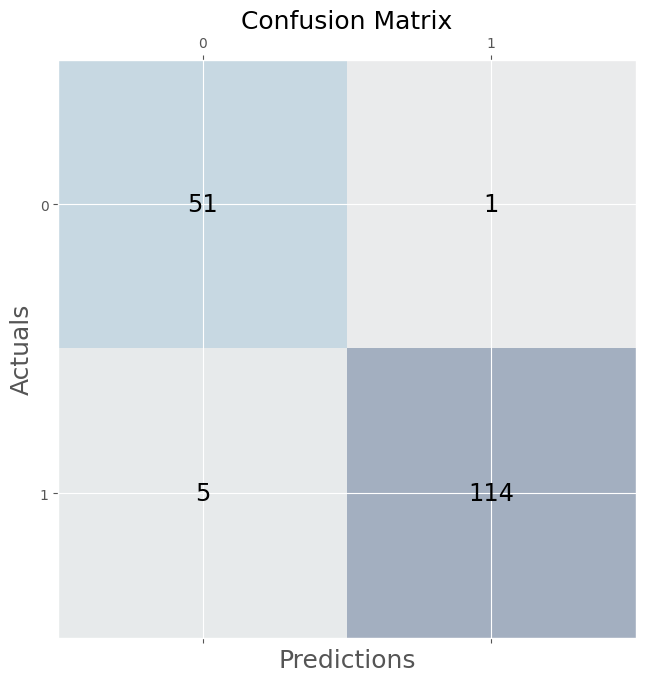

Accuracy  : 0.9649122807017544
Recall : 0.9649122807017544
specificity : 0.9807692307692307
Precision : 0.9667974283534925
f1Score : 0.9444444444444444
kappa score : 0.9188547927870927
gmean : 0.972808447385015
Confusion Matrix

[[ 51   1]
 [  5 114]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.96      0.97       119
      NORMAL       0.91      0.98      0.94        52

    accuracy                           0.96       171
   macro avg       0.95      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171

AUC-ROC: 0.969376212023271


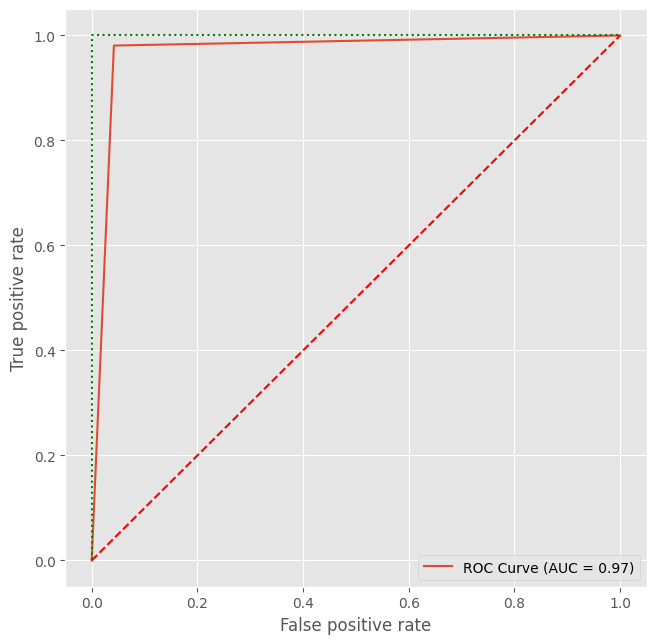

VALIDATION DENSENET RESULTS
22/22 [==============================] - 0s 11ms/step


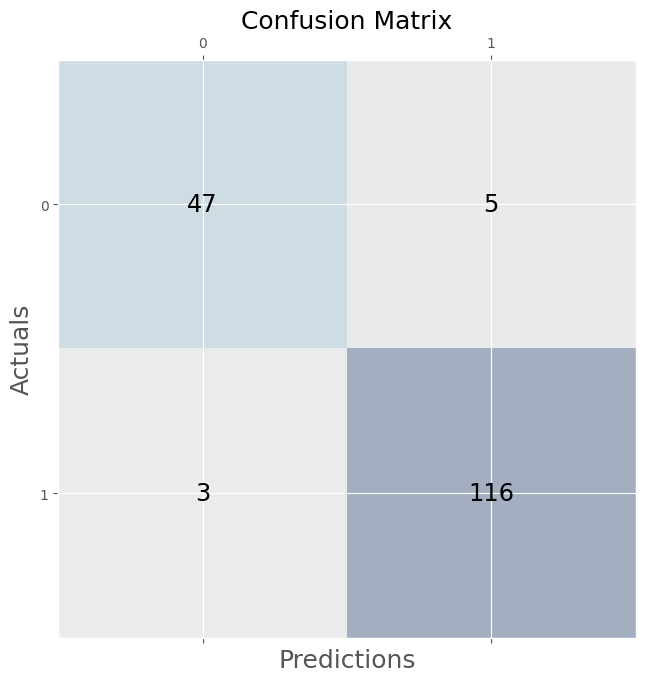

Accuracy  : 0.9532163742690059
Recall : 0.9532163742690059
specificity : 0.9038461538461539
Precision : 0.9529979218017495
f1Score : 0.9215686274509804
kappa score : 0.8882535533409573
gmean : 0.9282030778155268
Confusion Matrix

[[ 47   5]
 [  3 116]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.96      0.97      0.97       119
      NORMAL       0.94      0.90      0.92        52

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

AUC-ROC: 0.9393180349062701


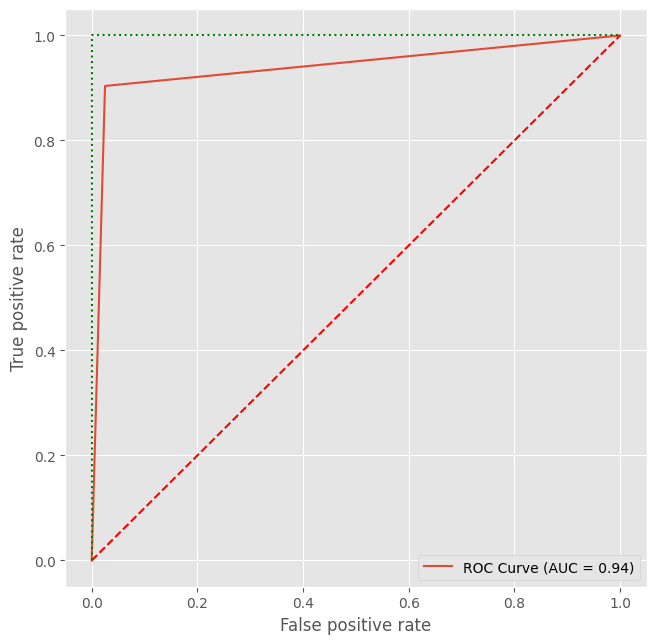

VALIDATION XCEPTION RESULTS
22/22 [==============================] - 0s 6ms/step


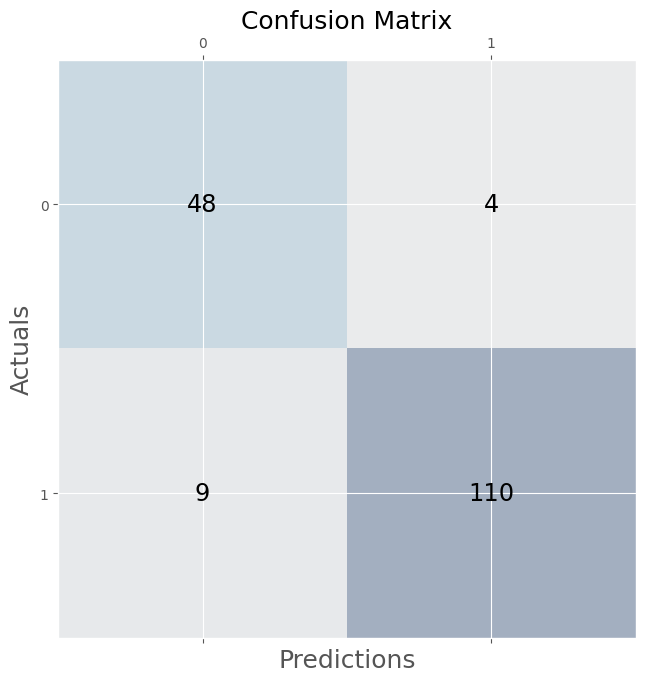

Accuracy  : 0.9239766081871345
Recall : 0.9239766081871345
specificity : 0.9230769230769231
Precision : 0.9275674566533292
f1Score : 0.8807339449541285
kappa score : 0.8251121076233183
gmean : 0.9235266560746538
Confusion Matrix

[[ 48   4]
 [  9 110]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.96      0.92      0.94       119
      NORMAL       0.84      0.92      0.88        52

    accuracy                           0.92       171
   macro avg       0.90      0.92      0.91       171
weighted avg       0.93      0.92      0.92       171

AUC-ROC: 0.9237233354880414


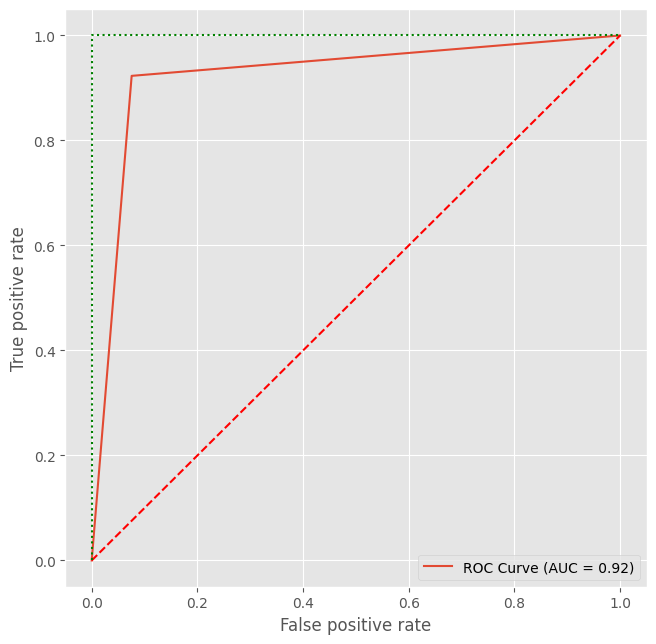

VALIDATION EFFICIENTNET RESULTS
22/22 [==============================] - 0s 6ms/step


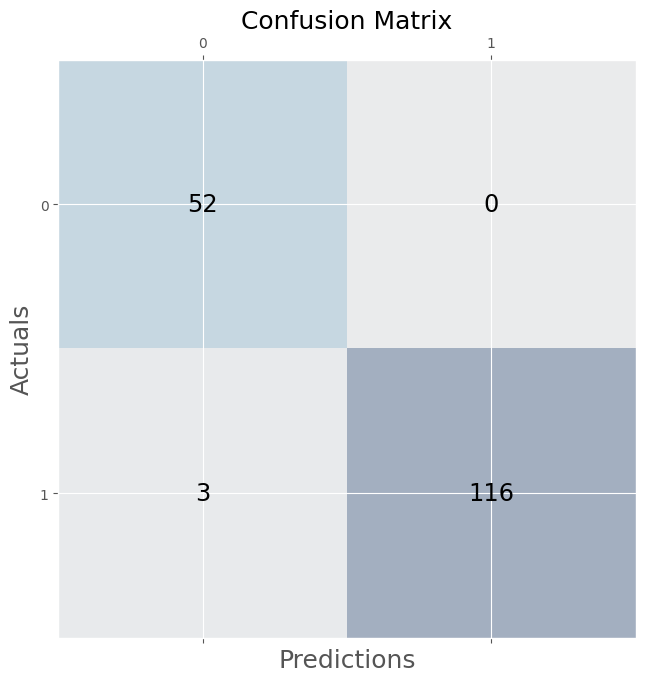

Accuracy  : 0.9824561403508771
Recall : 0.9824561403508771
specificity : 1.0
Precision : 0.9834130781499202
f1Score : 0.9719626168224299
kappa score : 0.9592112586467361
gmean : 0.9911892555667041
Confusion Matrix

[[ 52   0]
 [  3 116]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.97      0.99       119
      NORMAL       0.95      1.00      0.97        52

    accuracy                           0.98       171
   macro avg       0.97      0.99      0.98       171
weighted avg       0.98      0.98      0.98       171

AUC-ROC: 0.9873949579831932


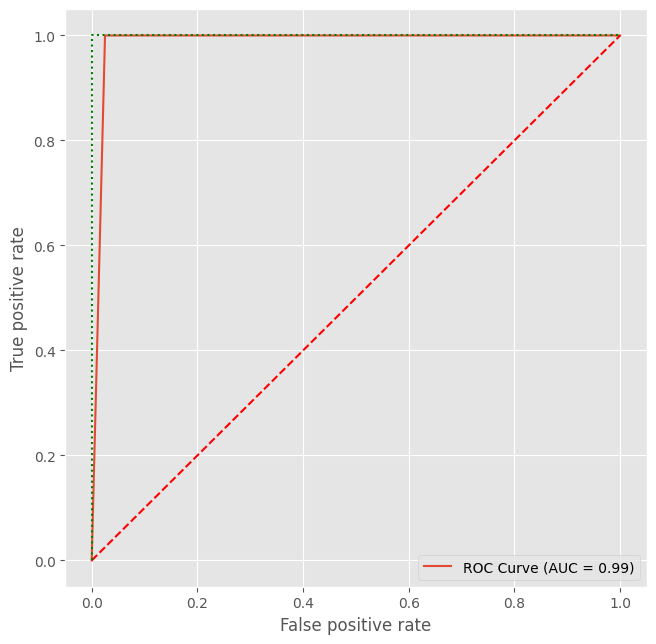

In [21]:
print("VALIDATION RESNET RESULTS")
bin_prediction(model_r, x_val, y_val)
#print("VALIDATION INCEPTION RESULTS")
#bin_prediction(model_i, x_val, y_val)
print("VALIDATION DENSENET RESULTS")
bin_prediction(model_d, x_val, y_val)
print("VALIDATION XCEPTION RESULTS")
bin_prediction(model_x, x_val, y_val)
print("VALIDATION EFFICIENTNET RESULTS")
bin_prediction(model_e, x_val, y_val)

In [22]:
print("TESTING DATASET EVALUATION")
print("TESTING DATASET - RESNET")
print(model_r.evaluate(x_test, y_test)) 
#print("TESTING DATASET - INCEPTION")
#print(model_i.evaluate(x_test, y_test)) 
print("TESTING DATASET - DENSENET")
print(model_d.evaluate(x_test, y_test))
print("TESTING DATASET - Xception")
print(model_x.evaluate(x_test, y_test))
print("TESTING DATASET - EFFICIENTNET")
print(model_e.evaluate(x_test, y_test))


TESTING DATASET EVALUATION
TESTING DATASET - RESNET
6/6 [==============================] - 0s 14ms/step - loss: 0.2060 - accuracy: 0.9826 - recall_4: 0.9831 - precision_4: 0.9667 - specificity_at_sensitivity_4: 0.9912 - auc_4: 0.9870
[0.20602771639823914, 0.9825581312179565, 0.9830508232116699, 0.9666666388511658, 0.991150438785553, 0.9869505763053894]
TESTING DATASET - DENSENET
6/6 [==============================] - 0s 18ms/step - loss: 0.3123 - accuracy: 0.9709 - recall_5: 0.9661 - precision_5: 0.9500 - specificity_at_sensitivity_5: 0.9823 - auc_5: 0.9807
[0.3123440742492676, 0.9709302186965942, 0.9661017060279846, 0.949999988079071, 0.982300877571106, 0.980725884437561]
TESTING DATASET - Xception
6/6 [==============================] - 0s 15ms/step - loss: 13.2126 - accuracy: 0.8895 - recall_6: 0.8814 - precision_6: 0.8125 - specificity_at_sensitivity_6: 0.9027 - auc_6: 0.8915
[13.212606430053711, 0.8895348906517029, 0.8813559412956238, 0.8125, 0.9026548862457275, 0.8914805054664612]

In [23]:
print("TRAINING DATASET EVALUATION")
print("TRAINING DATASET - RESNET")
print(model_r.evaluate(x_train, y_train)) 
#print("TRAINING DATASET - INCEPTION")
#print(model_i.evaluate(x_train, y_train)) 
print("TRAINING DATASET - DENSENET")
print(model_d.evaluate(x_train, y_train)) 
print("TRAINING DATASET - XCEPTION")
print(model_x.evaluate(x_train, y_train)) 
print("TRAINING DATASET - EFFICIENTNET")
print(model_e.evaluate(x_train, y_train)) 

TRAINING DATASET EVALUATION
TRAINING DATASET - RESNET
43/43 [==============================] - 1s 14ms/step - loss: 2.0681e-07 - accuracy: 1.0000 - recall_4: 1.0000 - precision_4: 1.0000 - specificity_at_sensitivity_4: 1.0000 - auc_4: 1.0000
[2.0681146395418182e-07, 1.0, 1.0, 1.0, 1.0, 1.0]
TRAINING DATASET - DENSENET
43/43 [==============================] - 1s 18ms/step - loss: 5.1768e-06 - accuracy: 1.0000 - recall_5: 1.0000 - precision_5: 1.0000 - specificity_at_sensitivity_5: 1.0000 - auc_5: 1.0000
[5.176828835828928e-06, 1.0, 1.0, 1.0, 1.0, 1.0]
TRAINING DATASET - XCEPTION
43/43 [==============================] - 1s 15ms/step - loss: 1.1046e-10 - accuracy: 1.0000 - recall_6: 1.0000 - precision_6: 1.0000 - specificity_at_sensitivity_6: 1.0000 - auc_6: 1.0000
[1.1045590830871532e-10, 1.0, 1.0, 1.0, 1.0, 1.0]
TRAINING DATASET - EFFICIENTNET
43/43 [==============================] - 1s 14ms/step - loss: 1.2384e-04 - accuracy: 1.0000 - recall_7: 1.0000 - precision_7: 1.0000 - specificit

In [24]:
print("TRAINING DATASET EVALUATION")

print("TRAINING DATASET - DENSENET")
print(model_d.evaluate(x_train, y_train)) 

TRAINING DATASET EVALUATION
TRAINING DATASET - DENSENET
43/43 [==============================] - 1s 18ms/step - loss: 5.1768e-06 - accuracy: 1.0000 - recall_5: 1.0000 - precision_5: 1.0000 - specificity_at_sensitivity_5: 1.0000 - auc_5: 1.0000
[5.176828835828928e-06, 1.0, 1.0, 1.0, 1.0, 1.0]


In [25]:
print("VALIDATION DATASET EVALUATION")
print("TESTING DATASET - RESNET")
print(model_r.evaluate(x_val, y_val)) 
print("TESTING DATASET - INCEPTION")
print(model_i.evaluate(x_val, y_val)) 
print("TESTING DATASET - DENSENET")
print(model_d.evaluate(x_val, y_val)) 

VALIDATION DATASET EVALUATION
TESTING DATASET - RESNET
6/6 [==============================] - 0s 14ms/step - loss: 0.6994 - accuracy: 0.9708 - recall_4: 1.0000 - precision_4: 0.9123 - specificity_at_sensitivity_4: 0.9580 - auc_4: 0.9782
[0.6993870735168457, 0.9707602262496948, 1.0, 0.9122806787490845, 0.9579831957817078, 0.9781835675239563]
TESTING DATASET - INCEPTION


NameError: name 'model_i' is not defined

In [10]:
def run_model(model, str):
    #model.summary()
    optimizer = tf.optimizers.Adam(
        learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics = ['accuracy', 
                         tf.keras.metrics.Recall(), 
                         tf.keras.metrics.Precision(), 
                         tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.8), 
                         tf.keras.metrics.AUC()
                        ])
                         
    log_filepath = checkpoint_filepath + str+ "_log_LIDC_bin.csv"

    csv_logger = CSVLogger(
    log_filepath, separator=',', append=True
    )


    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=100,
        validation_data=(x_val, y_val),
        #validation_split=0.1,
        callbacks=[csv_logger],
    )

    print(model.evaluate(x_test, y_test)) 
    model.save(str + "model_log_LIDC_bin.h5")
    return history, model

In [11]:
import math 
def my_metrics(y_true, yPredictions):
       
    accuracy=accuracy_score(y_true, yPredictions)
    precision=precision_score(y_true, yPredictions,average='weighted')
    recall=recall_score(y_true, yPredictions,average='weighted')
    #f1_Score=f1_score(y_true, yPredictions) 
    cm=confusion_matrix(y_true, yPredictions, labels = [1,0])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    kscore=cohen_kappa_score(y_true, yPredictions)
    gmean = math.sqrt(recall*specificity)
    f1score=f1_score(y_true, yPredictions)
    
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    print("Accuracy  : {}".format(accuracy))
    print("Recall : {}".format(recall))
    print("specificity : {}".format(specificity))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1score))
    print("kappa score :", kscore)
    print("gmean : {}".format(gmean))
    
    print("Confusion Matrix\n")
    print(cm)

    print('Classification Report')
    target_names = ['ABNORMAL', 'NORMAL']
    print(classification_report(y_true, yPredictions, target_names=target_names))
    

In [12]:
def bin_prediction(classifier, x_test, y_test):
    pred = classifier.predict(x_test,batch_size=8,verbose=1)
    yPredictions = []

    for i in pred:
        if i >=0.6:
            yPredictions.append(1)
        else:
            yPredictions.append(0)

    true_classes = y_test
    true_classes = true_classes.astype(int) 

    my_metrics(true_classes, yPredictions)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    print('AUC-ROC:',roc_auc_score(true_classes, yPredictions))
    fpr, tpr, thresholds = roc_curve(true_classes, yPredictions, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC Curve' + " " '(AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')   
    plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc="lower right")
    plt.show()

mVGG MODEL

In [13]:
vgg = VGG16(input_shape = (224,224,3), weights='imagenet', include_top=False)

In [14]:
def create_mVGG():
    for layer in vgg.layers[:15]:
        layer.trainable = False
        
    for i, layer in enumerate(vgg.layers):
        print(i, layer.name, layer.trainable)
    
    x = vgg.get_layer("block4_pool").output
    x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    #x = Dense(64,activation= "relu")(x)
    out = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=vgg.input, outputs=out)   
    return model

In [15]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, MaxPool2D,GlobalMaxPool2D,  BatchNormalization

In [16]:
model_mVGG= create_mVGG()

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [17]:
model_v = create_vgg()
model_i = create_incepnet()

In [18]:
hist_v, model_v = run_model(model_v, "vgg")
hist_mVGG, model_mVGG = run_model(model_mVGG, "mVGG")
hist_i, model_i = run_model(model_i, "incepnet")

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-26 08:25:31.045670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-07-26 08:25:31.454485: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa238ca1440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 08:25:31.454533: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-07-26 08:25:31.459487: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-26 08:25:31.583439: I tensorflow/compiler/jit/xla_compilation

486/486 [==============================] - 14s 25ms/step - loss: 0.7575 - accuracy: 0.8474 - recall: 0.7909 - precision: 0.8096 - specificity_at_sensitivity: 0.8673 - auc: 0.8943 - val_loss: 1.0669 - val_accuracy: 0.7904 - val_recall: 0.8874 - val_precision: 0.6721 - val_specificity_at_sensitivity: 0.9005 - val_auc: 0.8882
Epoch 2/100
486/486 [==============================] - 12s 24ms/step - loss: 0.4554 - accuracy: 0.8993 - recall: 0.8600 - precision: 0.8768 - specificity_at_sensitivity: 0.9741 - auc: 0.9436 - val_loss: 1.4901 - val_accuracy: 0.8692 - val_recall: 0.6783 - val_precision: 0.9731 - val_specificity_at_sensitivity: 0.0000e+00 - val_auc: 0.8799
Epoch 3/100
486/486 [==============================] - 11s 24ms/step - loss: 0.3573 - accuracy: 0.9208 - recall: 0.8868 - precision: 0.9060 - specificity_at_sensitivity: 0.9872 - auc: 0.9601 - val_loss: 0.7288 - val_accuracy: 0.9078 - val_recall: 0.8016 - val_precision: 0.9507 - val_specificity_at_sensitivity: 0.9758 - val_auc: 0.92

2023-07-26 08:44:55.255486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


486/486 [==============================] - 13s 24ms/step - loss: 3.9697 - accuracy: 0.8272 - recall_1: 0.6230 - precision_1: 0.8983 - specificity_at_sensitivity_1: 0.5711 - auc_1: 0.8266 - val_loss: 0.4845 - val_accuracy: 0.8697 - val_recall_1: 0.7694 - val_precision_1: 0.8763 - val_specificity_at_sensitivity_1: 0.0075 - val_auc_1: 0.8752
Epoch 2/100
486/486 [==============================] - 11s 23ms/step - loss: 0.4309 - accuracy: 0.8624 - recall_1: 0.6622 - precision_1: 0.9728 - specificity_at_sensitivity_1: 0.5759 - auc_1: 0.8333 - val_loss: 0.3896 - val_accuracy: 0.8723 - val_recall_1: 0.6810 - val_precision_1: 0.9807 - val_specificity_at_sensitivity_1: 0.0067 - val_auc_1: 0.8534
Epoch 3/100
486/486 [==============================] - 11s 23ms/step - loss: 0.3798 - accuracy: 0.8743 - recall_1: 0.6951 - precision_1: 0.9713 - specificity_at_sensitivity_1: 0.6731 - auc_1: 0.8549 - val_loss: 0.3238 - val_accuracy: 0.8965 - val_recall_1: 0.7587 - val_precision_1: 0.9642 - val_specificit

vgg RESULTS
243/243 [==============================] - 2s 6ms/step


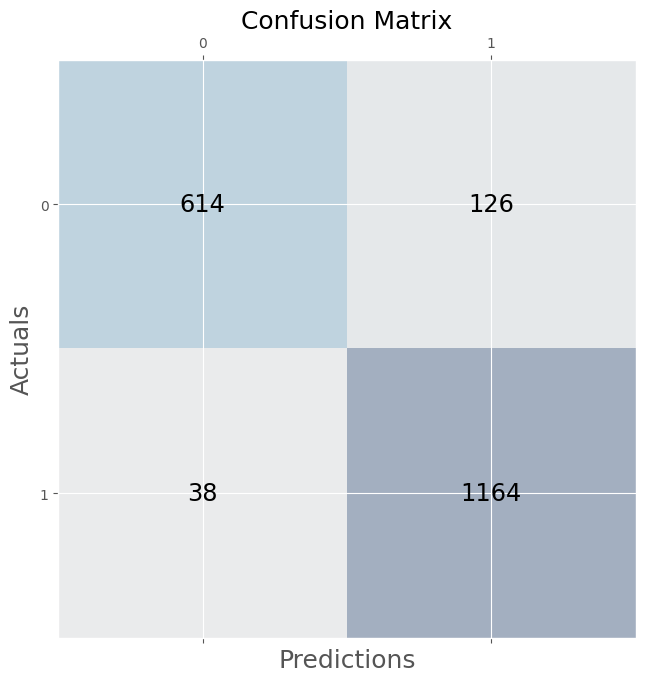

Accuracy  : 0.9155509783728115
Recall : 0.9155509783728115
specificity : 0.8297297297297297
Precision : 0.9173360012777452
f1Score : 0.882183908045977
kappa score : 0.8167823349655756
gmean : 0.8715846865560813
Confusion Matrix

[[ 614  126]
 [  38 1164]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.90      0.97      0.93      1202
      NORMAL       0.94      0.83      0.88       740

    accuracy                           0.92      1942
   macro avg       0.92      0.90      0.91      1942
weighted avg       0.92      0.92      0.91      1942

AUC-ROC: 0.8990578765121195


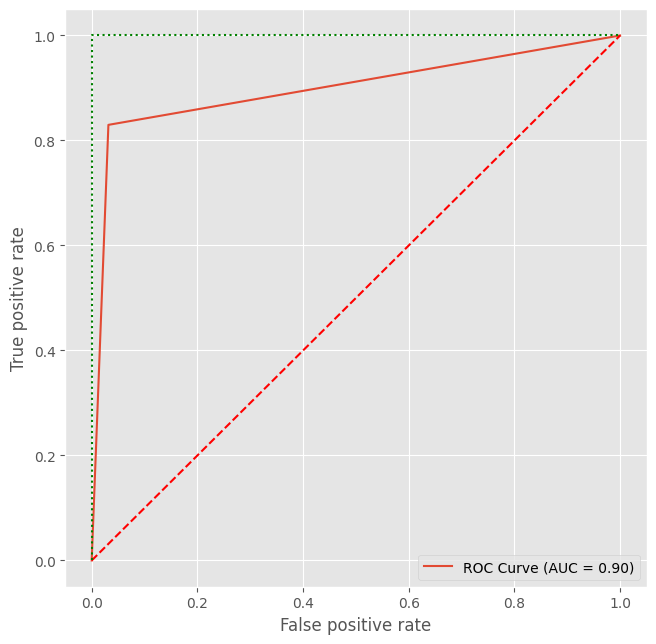

INCEPTION RESULTS
243/243 [==============================] - 3s 7ms/step


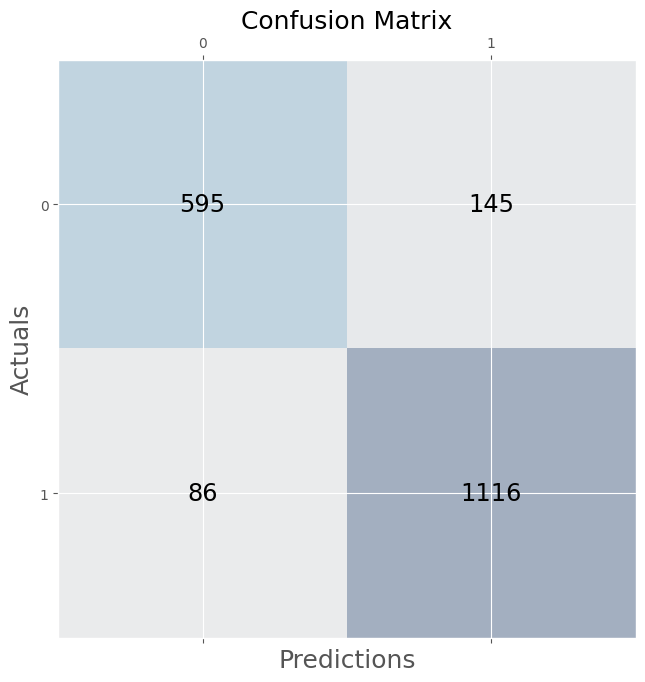

Accuracy  : 0.8810504634397528
Recall : 0.8810504634397528
specificity : 0.8040540540540541
Precision : 0.8807072556849749
f1Score : 0.8374384236453203
kappa score : 0.7439050706113255
gmean : 0.8416722621988539
Confusion Matrix

[[ 595  145]
 [  86 1116]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.89      0.93      0.91      1202
      NORMAL       0.87      0.80      0.84       740

    accuracy                           0.88      1942
   macro avg       0.88      0.87      0.87      1942
weighted avg       0.88      0.88      0.88      1942

AUC-ROC: 0.8662533165444979


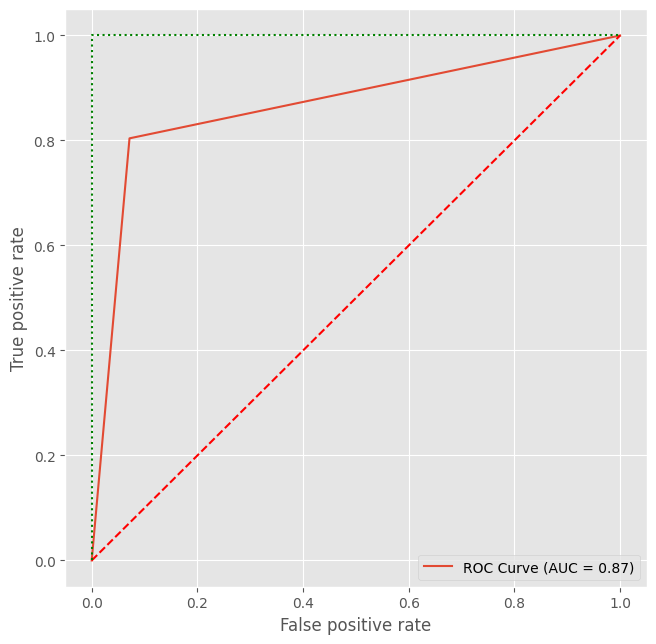

mVGG RESULTS
243/243 [==============================] - 1s 5ms/step


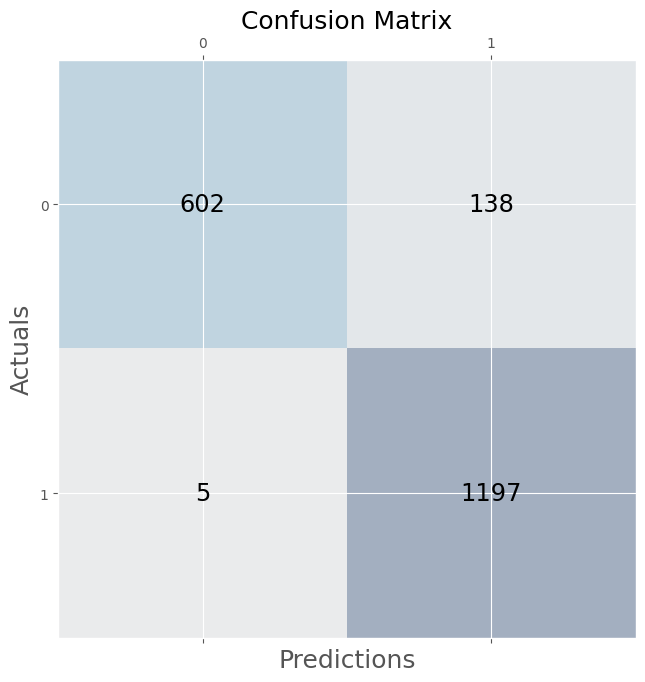

Accuracy  : 0.9263645726055613
Recall : 0.9263645726055613
specificity : 0.8135135135135135
Precision : 0.9328798984099784
f1Score : 0.8938381588715665
kappa score : 0.8383093238250169
gmean : 0.8681071928366879
Confusion Matrix

[[ 602  138]
 [   5 1197]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.90      1.00      0.94      1202
      NORMAL       0.99      0.81      0.89       740

    accuracy                           0.93      1942
   macro avg       0.94      0.90      0.92      1942
weighted avg       0.93      0.93      0.92      1942

AUC-ROC: 0.9046768898682376


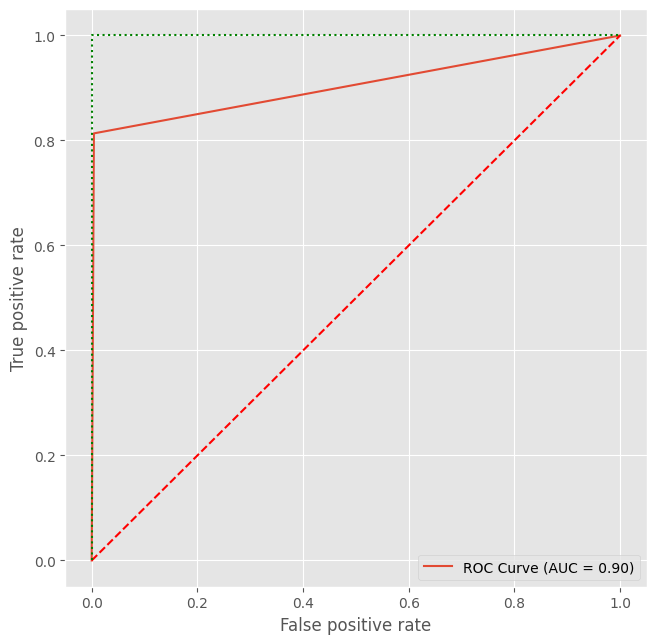

In [19]:
print("vgg RESULTS")
bin_prediction(model_v, x_test, y_test)

print("INCEPTION RESULTS")
bin_prediction(model_i, x_test, y_test)
print("mVGG RESULTS")
bin_prediction(model_mVGG, x_test, y_test)


TRAINING vgg RESULTS
1942/1942 [==============================] - 11s 6ms/step


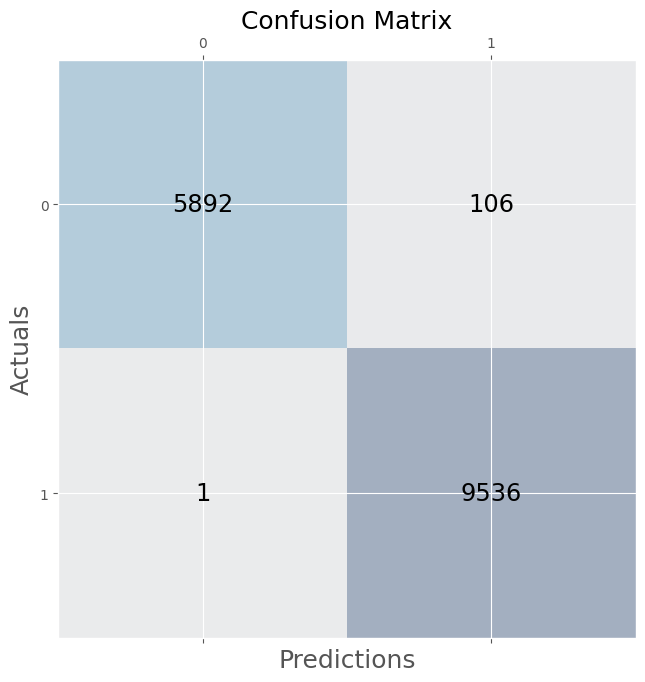

Accuracy  : 0.9931123270035404
Recall : 0.9931123270035404
specificity : 0.9823274424808269
Precision : 0.9931854848457676
f1Score : 0.9910015978471113
kappa score : 0.9854232838119864
gmean : 0.9877051646526763
Confusion Matrix

[[5892  106]
 [   1 9536]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.99      1.00      0.99      9537
      NORMAL       1.00      0.98      0.99      5998

    accuracy                           0.99     15535
   macro avg       0.99      0.99      0.99     15535
weighted avg       0.99      0.99      0.99     15535

AUC-ROC: 0.9911112938523459


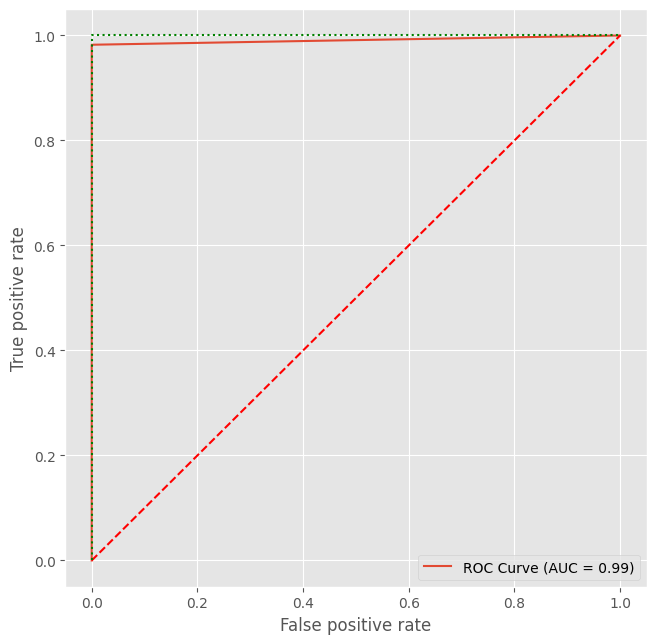

TRAINING INCEPTION RESULTS
1942/1942 [==============================] - 12s 6ms/step


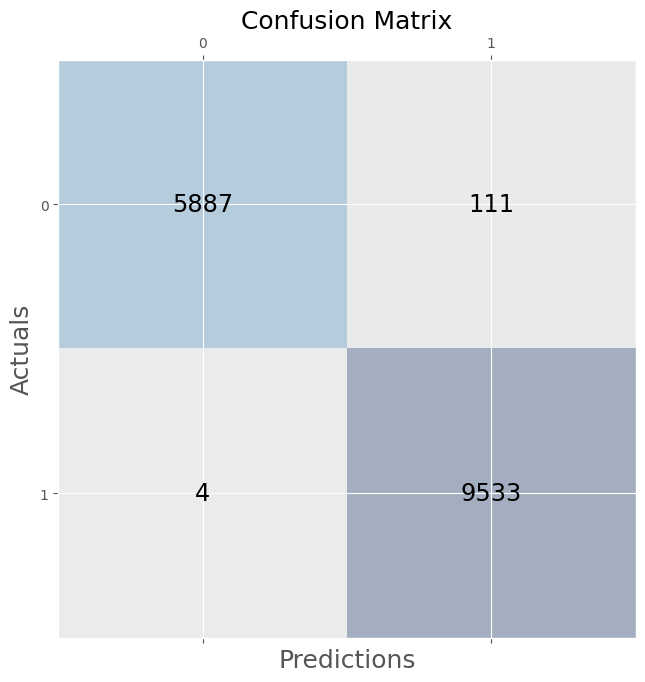

Accuracy  : 0.9925973607981976
Recall : 0.9925973607981976
specificity : 0.9814938312770923
Precision : 0.9926719594289314
f1Score : 0.9903271932038018
kappa score : 0.9843324634033084
gmean : 0.9870299826070904
Confusion Matrix

[[5887  111]
 [   4 9533]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.99      1.00      0.99      9537
      NORMAL       1.00      0.98      0.99      5998

    accuracy                           0.99     15535
   macro avg       0.99      0.99      0.99     15535
weighted avg       0.99      0.99      0.99     15535

AUC-ROC: 0.990537206086276


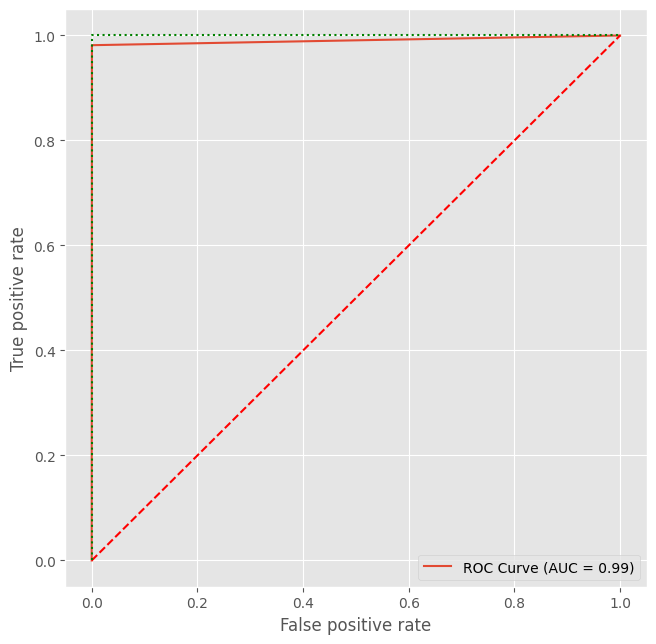

TRAINING mVGG RESULTS
1942/1942 [==============================] - 10s 5ms/step


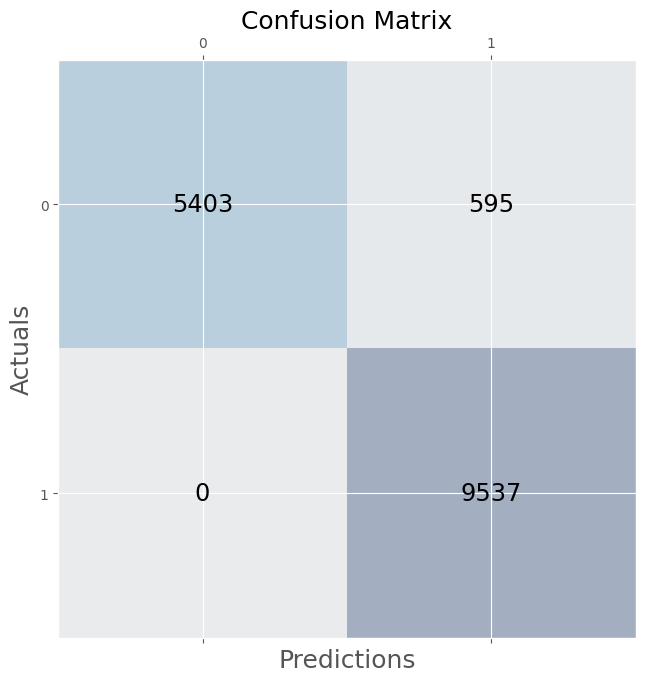

Accuracy  : 0.9616993884776311
Recall : 0.9616993884776311
specificity : 0.9008002667555852
Precision : 0.9639485854630051
f1Score : 0.9478115954740812
kappa score : 0.9176908913574263
gmean : 0.9307518819101755
Confusion Matrix

[[5403  595]
 [   0 9537]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.94      1.00      0.97      9537
      NORMAL       1.00      0.90      0.95      5998

    accuracy                           0.96     15535
   macro avg       0.97      0.95      0.96     15535
weighted avg       0.96      0.96      0.96     15535

AUC-ROC: 0.9504001333777926


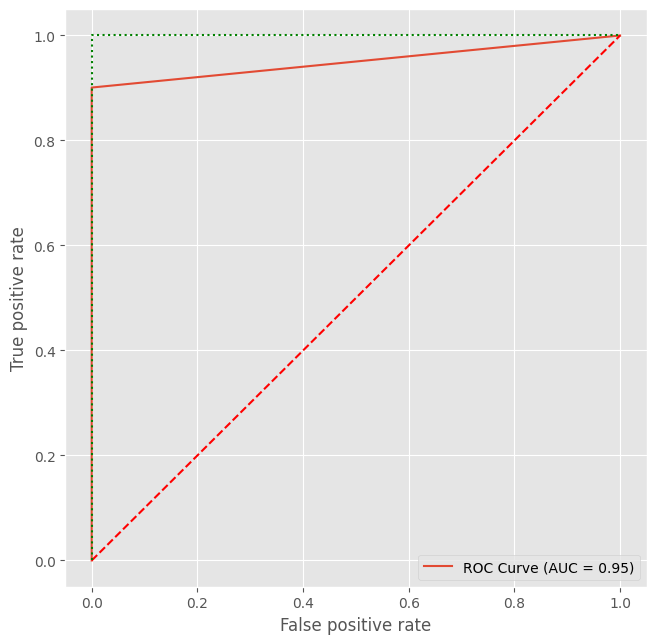

In [20]:
print("TRAINING vgg RESULTS")
bin_prediction(model_v, x_train, y_train)
print("TRAINING INCEPTION RESULTS")
bin_prediction(model_i, x_train, y_train)
print("TRAINING mVGG RESULTS")
bin_prediction(model_mVGG, x_train, y_train)

VALIDATION vgg RESULTS
243/243 [==============================] - 1s 6ms/step


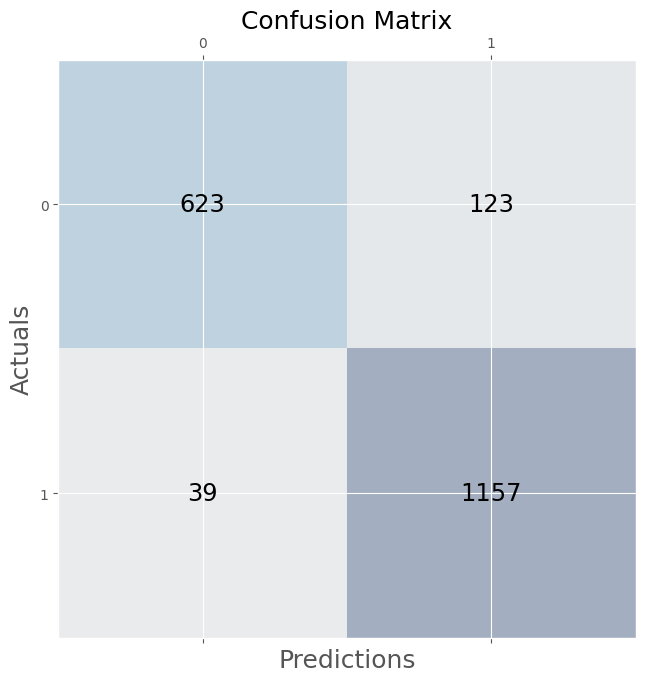

Accuracy  : 0.9165808444902163
Recall : 0.9165808444902163
specificity : 0.8351206434316354
Precision : 0.9181891011929023
f1Score : 0.8849431818181818
kappa score : 0.8198796311987872
gmean : 0.8749031858484578
Confusion Matrix

[[ 623  123]
 [  39 1157]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.90      0.97      0.93      1196
      NORMAL       0.94      0.84      0.88       746

    accuracy                           0.92      1942
   macro avg       0.92      0.90      0.91      1942
weighted avg       0.92      0.92      0.92      1942

AUC-ROC: 0.9012559738897307


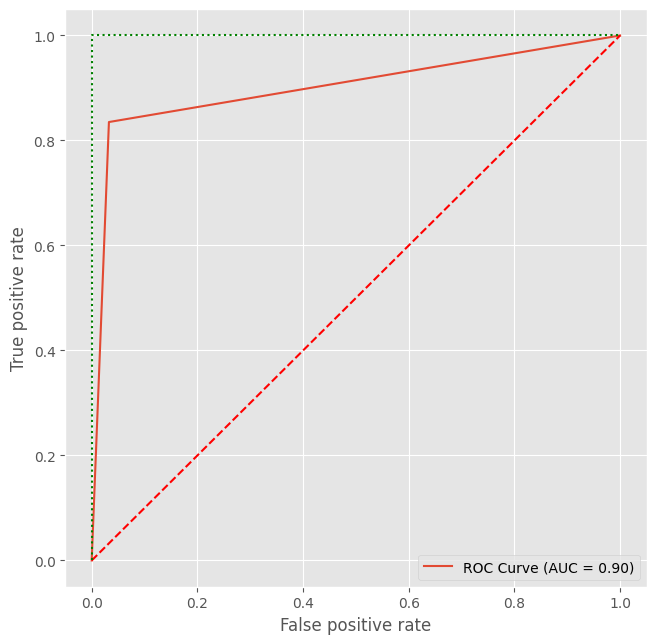

VALIDATION INCEPTION RESULTS
243/243 [==============================] - 2s 6ms/step


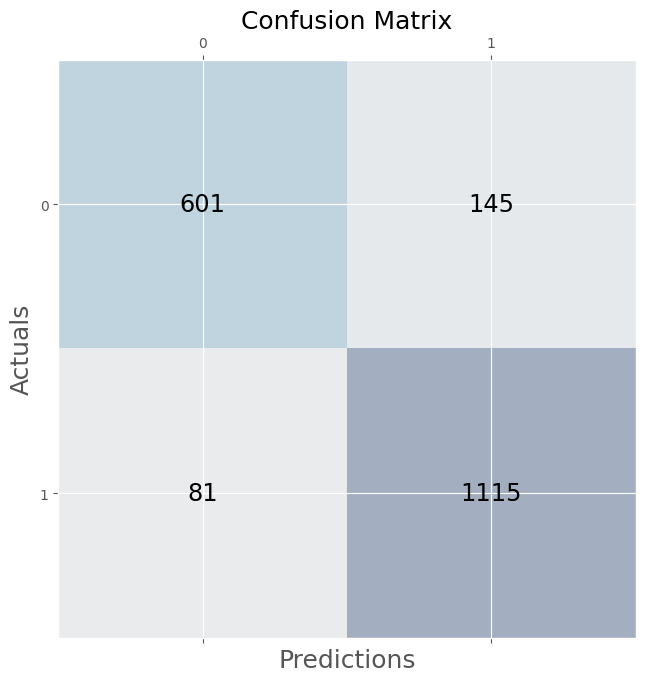

Accuracy  : 0.8836251287332647
Recall : 0.8836251287332647
specificity : 0.8056300268096515
Precision : 0.8835035563051242
f1Score : 0.8417366946778712
kappa score : 0.7500091135272084
gmean : 0.8437268136968635
Confusion Matrix

[[ 601  145]
 [  81 1115]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.88      0.93      0.91      1196
      NORMAL       0.88      0.81      0.84       746

    accuracy                           0.88      1942
   macro avg       0.88      0.87      0.87      1942
weighted avg       0.88      0.88      0.88      1942

AUC-ROC: 0.8689521371506451


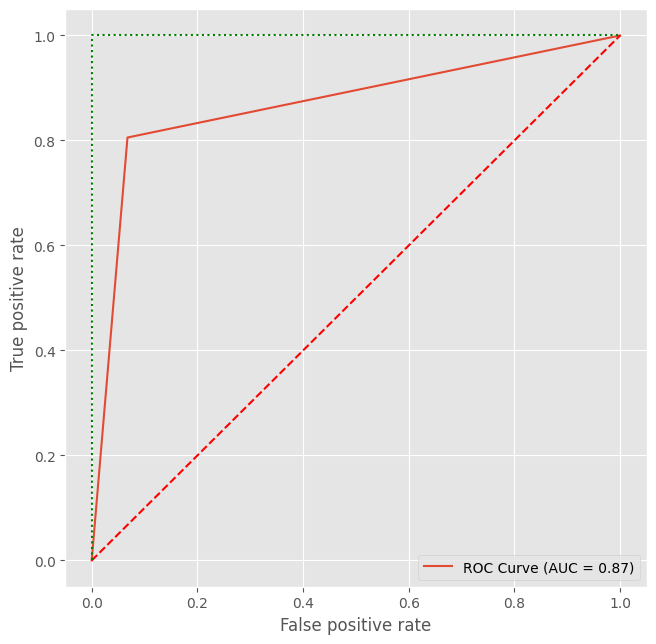

VALIDATION mVGG RESULTS
243/243 [==============================] - 1s 5ms/step


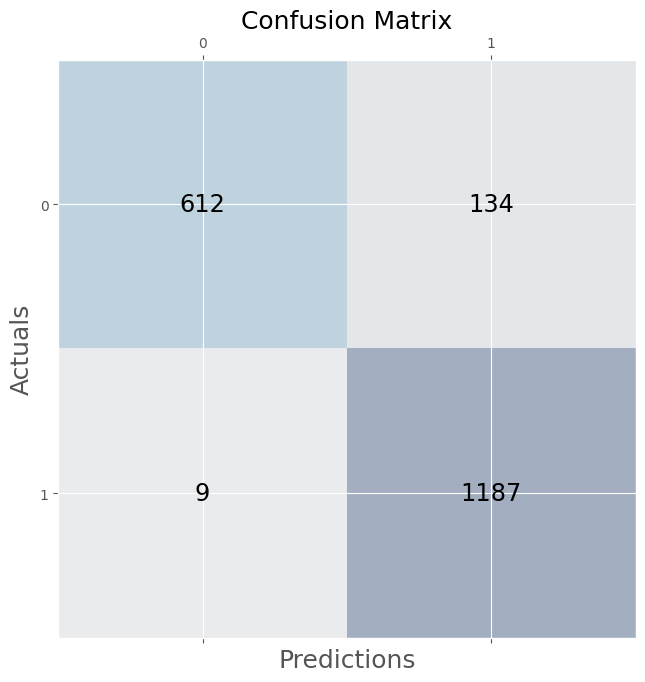

Accuracy  : 0.9263645726055613
Recall : 0.9263645726055613
specificity : 0.8203753351206434
Precision : 0.9319609649003426
f1Score : 0.8953913679590344
kappa score : 0.839307434054978
gmean : 0.8717606590659955
Confusion Matrix

[[ 612  134]
 [   9 1187]]
Classification Report
              precision    recall  f1-score   support

    ABNORMAL       0.90      0.99      0.94      1196
      NORMAL       0.99      0.82      0.90       746

    accuracy                           0.93      1942
   macro avg       0.94      0.91      0.92      1942
weighted avg       0.93      0.93      0.92      1942

AUC-ROC: 0.9064251257543017


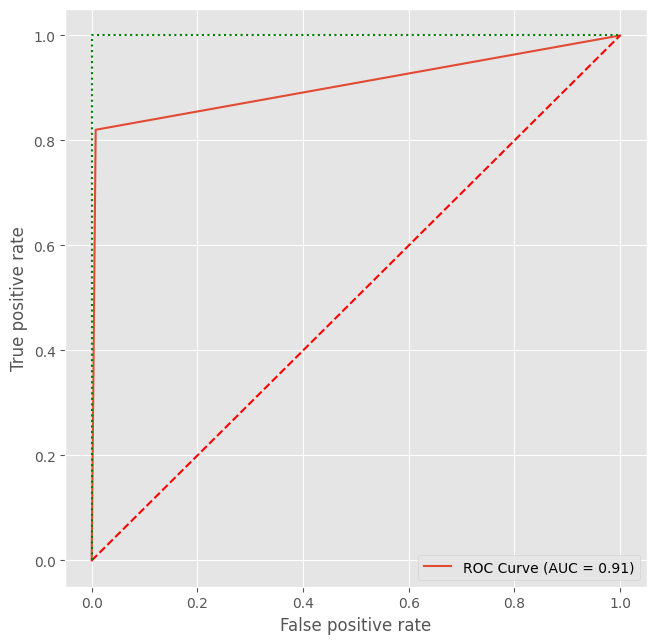

In [21]:
print("VALIDATION vgg RESULTS")
bin_prediction(model_v, x_val, y_val)
print("VALIDATION INCEPTION RESULTS")
bin_prediction(model_i, x_val, y_val)
print("VALIDATION mVGG RESULTS")
bin_prediction(model_mVGG, x_val, y_val)